In [1]:
%%capture
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext training_rl
%set_random_seed 12

In [2]:
%presentation_style

In [3]:
%load_latex_macros


$\newcommand{\vect}[1]{{\mathbf{\boldsymbol{#1}} }}$
$\newcommand{\amax}{{\text{argmax}}}$
$\newcommand{\P}{{\mathbb{P}}}$
$\newcommand{\E}{{\mathbb{E}}}$
$\newcommand{\R}{{\mathbb{R}}}$
$\newcommand{\Z}{{\mathbb{Z}}}$
$\newcommand{\N}{{\mathbb{N}}}$
$\newcommand{\C}{{\mathbb{C}}}$
$\newcommand{\abs}[1]{{ \left| #1 \right| }}$
$\newcommand{\simpl}[1]{{\Delta^{#1} }}$


In [9]:
%autoreload
from training_rl.offline_rl.load_env_variables import load_env_variables
load_env_variables()

import os
import warnings
from copy import copy, deepcopy
import numpy as np

import gymnasium as gym
import minari
import torch

from training_rl.offline_rl.behavior_policies.behavior_policy_registry import \
    BehaviorPolicyType
from training_rl.offline_rl.custom_envs.custom_2d_grid_env.obstacles_2D_grid_register import \
    ObstacleTypes
from training_rl.offline_rl.custom_envs.custom_envs_registration import (
    CustomEnv, RenderMode, register_grid_envs, EnvFactory)
from training_rl.offline_rl.custom_envs.utils import (
    Grid2DInitialConfig, InitialConfigCustom2DGridEnvWrapper)
from training_rl.offline_rl.generate_custom_minari_datasets.generate_minari_dataset_grid_envs import (
    MinariDatasetConfig, create_minari_datasets)
from training_rl.offline_rl.offline_policies.offpolicy_rendering import \
    offpolicy_rendering
from training_rl.offline_rl.offline_policies.policy_registry import PolicyName
from training_rl.offline_rl.offline_trainings.offline_training import \
    offline_training
from training_rl.offline_rl.offline_trainings.policy_config_data_class import (
    TrainedPolicyConfig, get_trained_policy_path)
from training_rl.offline_rl.offline_trainings.restore_policy_model import \
    restore_trained_offline_policy
from training_rl.offline_rl.utils import (compare_state_action_histograms,
                                          load_buffer_minari,
                                          state_action_histogram)
from training_rl.offline_rl.visualizations.utils import (
    get_state_action_data_and_policy_grid_distributions, snapshot_env, trajectory_cumulative_rewards_plot)
from training_rl.offline_rl.utils import widget_list
from training_rl.offline_rl.generate_custom_minari_datasets.generate_minari_dataset_grid_envs import \
    create_combined_minari_dataset
from training_rl.offline_rl.utils import load_buffer_minari, widget_list
from tianshou.data import Batch
from training_rl.offline_rl.behavior_policies.behavior_policy_registry import \
    BehaviorPolicyRestorationConfigFactoryRegistry
from training_rl.offline_rl.offline_policies.policy_registry import PolicyFactoryRegistry
from training_rl.offline_rl.offline_policies.dagger_torcs_policy import model_dagger_fit
from training_rl.offline_rl.offline_trainings.training_decision_transformer import evaluate_on_env
from training_rl.offline_rl.offline_policies.decision_transformer_policy import get_decision_transformer_default_config, \
    create_decision_transformer_policy_from_dict
from matplotlib import pyplot as plt
import pickle
from itertools import accumulate
from training_rl.offline_rl.visualizations.utils import policy_rollout_torcs_env, \
    compare_policy_decisions_vs_expert_suggestions




warnings.filterwarnings("ignore")

if not os.environ.get("DISPLAY"):
    os.environ['MUJOCO_GL'] = 'egl'
    
render_mode = RenderMode.RGB_ARRAY_LIST

<img src="_static/images/aai-institute-cover.svg" alt="Snow" style="width:100%;">
<div class="md-slide title"> Imitation Learning </div>

# Imitation Learning Exercises

**Imitation learning is a supervised learning approach that focuses on learning policies or behaviors by observing and imitating expert demonstrations**.

This makes these algorithms appealing as, **you don't need to create a reward function for your task**.

We will begin with Behavioral Cloning (BC), as introduced earlier. Later, we will cover the well-known improvement DAGGER, and if time permits, Decision Transformers (DT).

Remember our pipeline for offline learning:

<img src="_static/images/93_offline_RL_pipeline.png" alt="Snow" style="width:50%;">

In this exercise, we will work with the full pipeline, selecting some imitation learning algorithms in step 4. 

Note: For the offline RL part, we will use the exact same pipeline but plug in our offline RL algorithms in step 4.

## Behavioral Clonning (BC)

It has been introduced previously, but let's remember the main ingredients:

$$ D = \{(s_0, a_0), (s_1, a_1), \ldots, (s_T, a_T)\} \quad \tag{Dataset} $$

$$\text{where} \quad \pi_{\theta^*}(s_t) \text{ s.t. } \theta^* = argmin_\theta  L_{BC}(\theta) \tag{learned policy}$$

$$\text{with} \quad L_{BC}(\theta) = \sum_{t=0}^T \left(\pi_\theta(s_t) - a_t\right)^2 \tag{Cost function}$$

and, $\pi_\theta(s_t)$, typically a DNN. **Note that there is no trace of rewards here.**

### Exercise I

In this exercise, we will:

1 - Study the out-of-distribution (o.o.d.) effect, as mentioned before, in a simple 2D grid-world environment.

<img src="_static/images/93_imitation_learning.png" alt="Snow" style="width:80%;">
<div class="slide title"> Fig.1 Once out-of-distribution BC agent is unlikely to recover </div>

2 - Evaluate how well BC handles noisy data, which is a common issue when working with collected expert data.

#### STEP 1: Create the environment

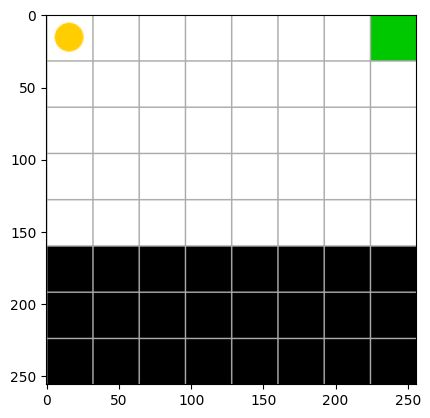

In [10]:
ENV_NAME = CustomEnv.Grid_2D_8x8_discrete.value

OBSTACLE = ObstacleTypes.obst_big_8x8
INITIAL_STATE = (0, 0)
FINAL_STATE = (0, 7)

env_2D_grid_initial_config = Grid2DInitialConfig(
    obstacles=OBSTACLE,
    initial_state=INITIAL_STATE,
    target_state=FINAL_STATE,
)

env = EnvFactory[ENV_NAME].get_env(render_mode=RenderMode.RGB_ARRAY_LIST,grid_config=env_2D_grid_initial_config)

snapshot_env(env)

#### STEP 2: Create Minari datasets

**Behavior policies and dataset configurations**

Note that we have more noisy data than expert information, as it is common in realistic problems, where expert (or close-to-expert) data is challenging to collect.

In [11]:
BEHAVIOR_POLICY_I = BehaviorPolicyType.behavior_8x8_suboptimal_initial_0_0_final_0_7
DATA_SET_IDENTIFIER_I = "_suboptimal_exercise_I_nb_93"
NUM_STEPS_I = 500

BEHAVIOR_POLICY_II = BehaviorPolicyType.random
DATA_SET_IDENTIFIER_II = "_random_exercise_I_nb_93"
NUM_STEPS_II = 2000

**Visualize behavior policies**

In [12]:
behavior_policy_selected = widget_list([BEHAVIOR_POLICY_I, BEHAVIOR_POLICY_II])

Dropdown(options=(<BehaviorPolicyType.behavior_8x8_suboptimal_initial_0_0_final_0_7: 'behavior_8x8_suboptimal_…

In [14]:
offpolicy_rendering(
    env_or_env_name=ENV_NAME,
    render_mode=render_mode,
    behavior_policy_name=behavior_policy_selected.value,
    env_2d_grid_initial_config=env_2D_grid_initial_config,
    num_frames=100,
    fps=8.0,
    inline=True
)

**Collect Minari dataset**

We will use the 'create_combined_minari_dataset(...)' function, which utilizes Minari's 'combine_datasets(...)' method in the backend, to merge different datasets.Please, give a look to the code.

In [15]:
# create the two collected datasets and merge them
config_combined_data = create_combined_minari_dataset(
        env_name=ENV_NAME,
        dataset_identifiers = (DATA_SET_IDENTIFIER_I, DATA_SET_IDENTIFIER_II),
        num_collected_points = (NUM_STEPS_I, NUM_STEPS_II),
        behavior_policy_names = (BEHAVIOR_POLICY_I, BEHAVIOR_POLICY_II),
        combined_dataset_identifier = "combined_dataset",
        env_2d_grid_initial_config = env_2D_grid_initial_config,
)

Dataset Grid_2D_8x8_discrete-data_obst_big_8x8_start_0_0_target_0_7_suboptimal_exercise_I_nb_93-v0 deleted!
Dataset Grid_2D_8x8_discrete-data_obst_big_8x8_start_0_0_target_0_7_random_exercise_I_nb_93-v0 deleted!
Dataset Grid_2D_8x8_discrete-combined_dataset-v0 deleted!
Number of episodes in dataset I:34, in dataset II:36 and  in the combined dataset: 70


#### STEP 3: Feed dataset to Tianshou ReplayBuffer

In [16]:
dataset_availables = [config_combined_data.data_set_name] + config_combined_data.children_dataset_names
selected_data_set = widget_list(dataset_availables)

Dropdown(options=('Grid_2D_8x8_discrete-combined_dataset-v0', 'Grid_2D_8x8_discrete-data_obst_big_8x8_start_0_…

Dataset /home/ivan/Documents/GIT_PROJECTS/tfl-training-rl/src/training_rl/offline_rl/data/offline_data/Grid_2D_8x8_discrete-combined_dataset-v0 downloaded. number of episodes: 70


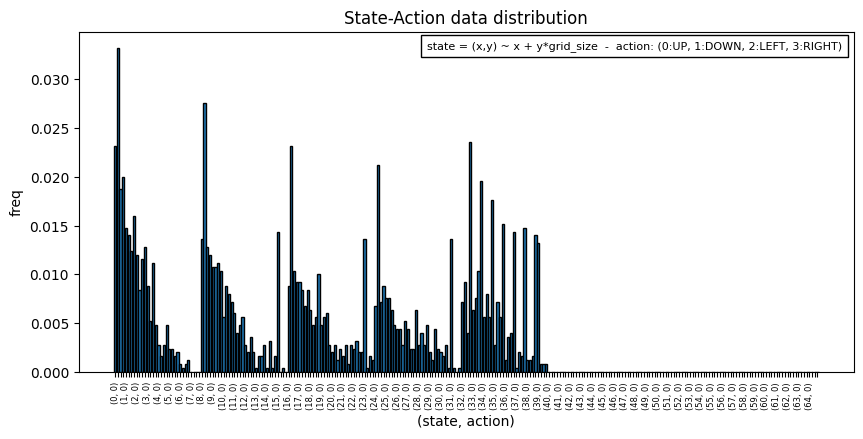

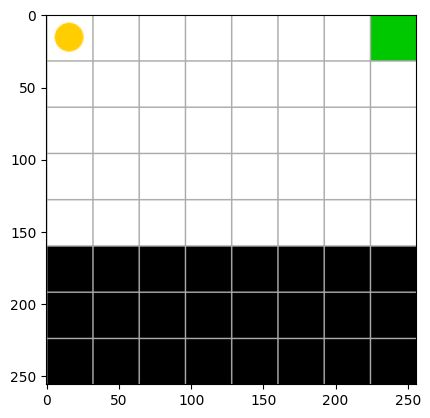

In [17]:
# feed selected Minari dataset into ReplayBuffer
buffer_data = load_buffer_minari(selected_data_set.value)
len_buffer = len(buffer_data)

# Compute state-action data distribution
state_action_count_data, _ = get_state_action_data_and_policy_grid_distributions(buffer_data, env)
state_action_histogram(state_action_count_data, title="State-Action data distribution")
snapshot_env(env)

Check that the state-action distributions make sense.

#### STEP 4-5: Select offline policy and training

Before we proceed, let's take a moment to become a little more familiar with the code. Let's spend some minutes reviewing:

    a - il_policy.py
    b - policy_registry.py
    c - offline_training.py


In [18]:
#The model policy to be trained.
POLICY_NAME = PolicyName.imitation_learning

NUM_EPOCHS = 5
BATCH_SIZE = 128
STEP_PER_EPOCH = len_buffer

# After every epoch we will collect some test statistics from the policy from NUMBER_TEST_ENVS independent envs.
NUMBER_TEST_ENVS = 1
EXPLORATION_NOISE = True
SEED = None #1626

# TrainedPolicyConfig is a handy object that will help us to deal with the policy configuration data.
offline_policy_config = TrainedPolicyConfig(
    name_expert_data=selected_data_set.value,
    policy_name=POLICY_NAME,
    render_mode=render_mode,
    device="cpu"
)

# Run the training
offline_training(
    offline_policy_config=offline_policy_config,
    num_epochs = NUM_EPOCHS,
    number_test_envs=NUMBER_TEST_ENVS,
    step_per_epoch=STEP_PER_EPOCH,
    restore_training=False,
    batch_size=BATCH_SIZE
)

Dataset /home/ivan/Documents/GIT_PROJECTS/tfl-training-rl/src/training_rl/offline_rl/data/offline_data/Grid_2D_8x8_discrete-combined_dataset-v0 downloaded. number of episodes: 70


Epoch #1: 2501it [00:04, 593.60it/s, gradient_step=2500, loss=1.283]                                                                                                                                        


Epoch #1: test_reward: -0.113899 ± 0.000000, best_reward: -0.032813 ± 0.000000 in #0


Epoch #2:  67%|################################################################################1                                       | 1670/2500 [00:02<00:01, 592.86it/s, gradient_step=4170, loss=1.282]


KeyboardInterrupt: 

**state-action BC policy distribution**

Processing: 100%|███████████████████████████████████████████████████| 40/40 [00:24<00:00,  1.65it/s]


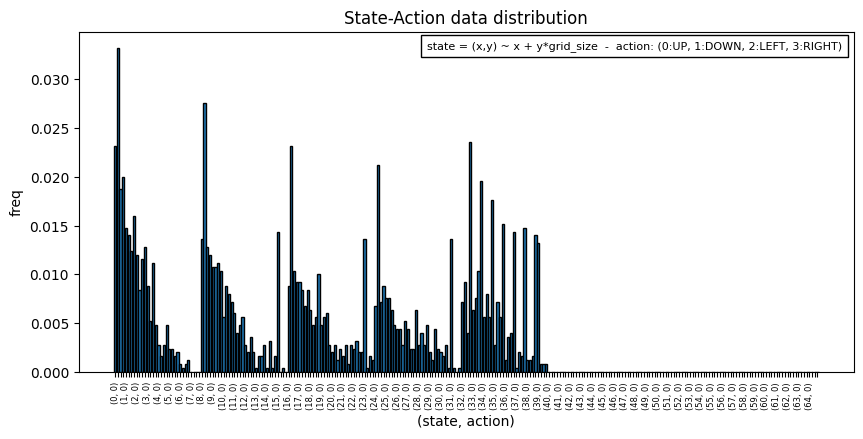

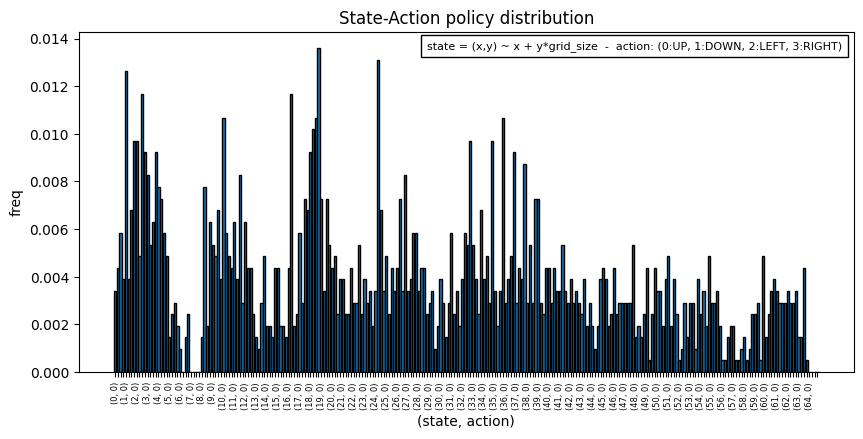

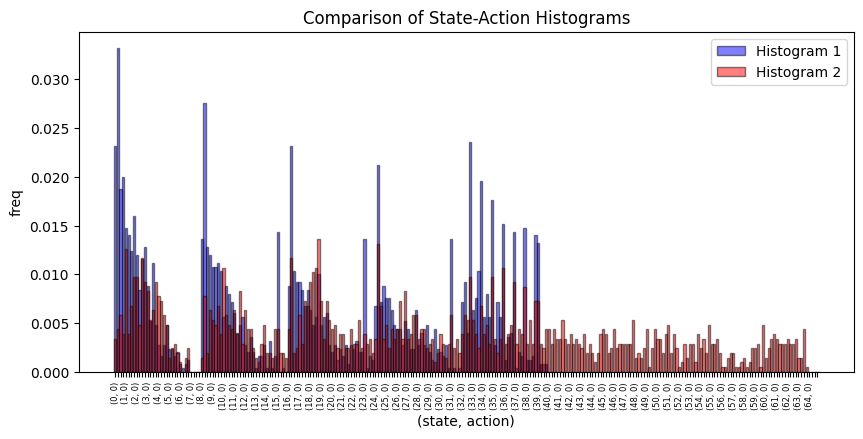

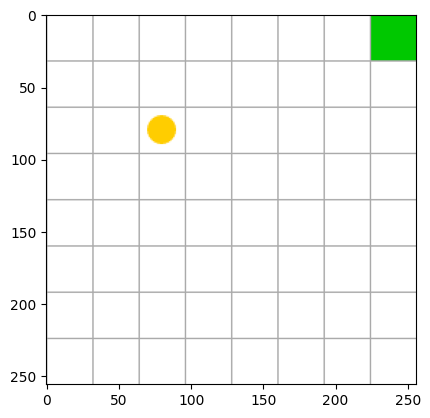

In [21]:
POLICY_FILE = "policy.pth"
NUM_EPISODES = 40 # as more episodes the better

# restore a policy with the same configuration as the one we trained.
policy = restore_trained_offline_policy(offline_policy_config)
# load the weights
name_expert_data = offline_policy_config.name_expert_data
log_name = os.path.join(name_expert_data, POLICY_NAME)
log_path = get_trained_policy_path(log_name)
policy.load_state_dict(torch.load(os.path.join(log_path, POLICY_FILE), map_location="cpu"))

# compute statistics
state_action_count_data, state_action_count_policy = \
    get_state_action_data_and_policy_grid_distributions(
    buffer_data, 
    env, 
    policy, 
    num_episodes=NUM_EPISODES,
    logits_sampling=True,
)

# plots
state_action_histogram(state_action_count_data, title="State-Action data distribution")
new_keys = [(env.to_xy(state_action[0]), state_action[1]) for state_action in list(state_action_count_data.keys())]
state_action_histogram(state_action_count_policy, title="State-Action policy distribution")
compare_state_action_histograms(state_action_count_data, state_action_count_policy)
snapshot_env(env)

As expected, the learned policy has a very similar distribution to the dataset!

**Visualize BC trained policy**

Below the imitation_policy_sampling=False arguments will give us the $\arg \max_a \pi(a|s)$. By setting it to True you will be sampling actions from the policy.

In [22]:
offpolicy_rendering(
    env_or_env_name=env,
    render_mode=render_mode,
    policy_model=policy,
    env_2d_grid_initial_config=env_2D_grid_initial_config,
    num_frames=100,
    imitation_policy_sampling=False
)

#### Summary and conclusions

**As our dataset includes a fair amount of expert data, by taking the $\arg \max_a \pi(s|a)$, we are able to remove the noise from the data and obtain the expert policy. This is a nice property of imitation learning! But if the expert data is not enough the BC algorithm will imitate the noise and the policy will be far from optimal.**

### Exercise II

Try now the following:

**a - Start the agent from a different position. What happens?.**

**b - Remove the obstacle and examine the state-action distribution. What do you observe? Can you explain it?.
      What do you think would happen if you start the agent from a previously forbidden position?**
      
**c -  Let's revisit Exercise I and see what happens if you increase the noise significantly, like to 40K-50K?**


Hint: You can use a different ObstacleTypes.obst_free_8x8 in your configuration and change the initial state, like this:

    NEW_INITIAL_STATE = (1,0)
    env.set_new_obstacle_map(ObstacleTypes.obst_free_8x8.value)
    env.set_starting_point(NEW_INITIAL_STATE)

**SOLUTION a**

In [19]:
obstacle_availables = [ObstacleTypes.obst_free_8x8, ObstacleTypes.obst_big_8x8]
selected_obstacle = widget_list(obstacle_availables)

Dropdown(options=(<ObstacleTypes.obst_free_8x8: ['00000000', '00000000', '00000000', '00000000', '00000000', '…

In [20]:
NEW_INITIAL_STATE = (2,2)
env.set_starting_point(NEW_INITIAL_STATE)
env.set_new_obstacle_map(selected_obstacle.value.value) #ObstacleTypes.obst_big_8x8

offpolicy_rendering(
    env_or_env_name=env,
    render_mode=RenderMode.RGB_ARRAY_LIST,
    policy_model=policy,
    num_frames=1000,
    imitation_policy_sampling=False
)

NameError: name 'policy' is not defined

**SOLUTION b**

In [ ]:
NUM_EPISODES = 20
env.set_starting_point((0,0))
env.set_new_obstacle_map(ObstacleTypes.obst_free_8x8.value)


state_action_count_data, state_action_count_policy = \
    get_state_action_data_and_policy_grid_distributions(
    buffer_data, 
    env, 
    policy, 
    num_episodes=NUM_EPISODES,
    logits_sampling=True,
)

state_action_histogram(state_action_count_data, title="State-Action data distribution")
new_keys = [(env.to_xy(state_action[0]), state_action[1]) for state_action in list(state_action_count_data.keys())]
state_action_histogram(state_action_count_policy, title="State-Action policy distribution")
compare_state_action_histograms(state_action_count_data, state_action_count_policy)
snapshot_env(env)

Keep in mind that in real-life scenarios, the forbidden zone—represented by the black region in the original environment—might correspond to a playground or a garden. There could be valid reasons for avoiding this area, so it's crucial not to enter it. If an agent does venture into this forbidden zone, it should strive to return to in-distribution states. Offline reinforcement learning (RL) addresses this challenge, as we will explore.

**SOLUTION c**

As you can see, increasing the noise level causes the trained policy to mimic the noise, resulting in a far from policy.

#### Conclusions

**DISTRIBUTIONAL SHIFT EFFECT**: As we observed in the previous exercises, a distributional shift effect often occurs, primarily due to out-of-distribution state-action pairs as the agent explores unfamiliar areas. This undesired effect is caused by function approximation, meaning that the DNN policy cannot perfectly represent the state-action distribution in regions with limited or no data. Eliminating this effect is crucial. Near unexplored regions, the policy's behavior becomes unpredictable.

### BC pros and cons

**Pros**:

a - BC becomes interesting when one has access to noisy expert data, as it provides a means to reduce noise from the expert data.

b - Another noteworthy aspect of BC is that it doesn't rely on rewards, making it a less complex solution to the problem of reward shaping in reinforcement learning.

**Cons**: 

a - in realistic applications, obtaining expert data is often a challenge. In many cases, we have access to only a limited number of trajectories, rendering this method less useful for extracting optimal policies. 

b - as we've observed, encountering o.o.d. scenarios (common during inference when visiting state-actions not included in the training dataset) causes BC to behave unpredictably. This unpredictability arises due to the lack of feedback typically present in online RL settings.

c - Additionally, simple imitation learning approaches often struggle to address an important property mentioned in the Minari datasets introduction (nb_91), known as the stitching property. This property refers to the ability of the learned policy to combine suboptimal trajectories into better ones, which is crucial in real-world problems.

We will explore later how offline RL provides a strategic approach to address these drawbacks.

## DAgger (Dataset Aggregation)

Improved versions of Behavioral Cloning (BC), such as DAgger (Dataset Aggregation), involve **rolling out the policy after initial BC training**. If **new states** emerge during rollout, **additional feedback is sought from human experts**. While this approach can lead to significant improvements, it can also incur substantial costs.

<img src="_static/images/93_DAGGER.jpg" alt="Snow" style="width:50%;">
<div class="slide title"> Fig.2: DAGGER idea </div>

<img src="_static/images/93_dagger_pseudocode.png" alt="Snow" style="width:80%;">
<div class="slide title"> Fig.2: DAGGER pseudocde </div>

Note that the error in Dagger is: $$ \mathbb{E} \left[ \sum_t c(s_t, a_t) \right] \sim O(\epsilon H)$$


In summary:

**-DAGGER is powerful but impractical: it gradually expands the dataset by incorporating new states and actions with expert knowledge in each iteration.**

**-DAGGER introduced a usually complex reward implicitly through the expert feedback**

**-DAGGER aligns more closely with online RL methodologies as in offline RL, states not included in the dataset are inaccessible.**

### Exercise III

In this exercise we will train a self-driving car in the TORCS race simulator.

#### TORCS race simulator quick overview

TORCS (The Open Racing Car Simulator) is a free 3D car racing game made in C++ (it includes aerodynamics, wheel rotation, car damage, fuel, etc.)

<img src="_static/images/93_TORCS_simulator.png" alt="Snow" style="width:50%;">
<div class="slide title"> Fig 3: TORCS simulator </div>

**We have created a Gymnasium environment for the simulator** that collect info through the server for training.

**Observation space**: 19-ray lidar.

**Action space**: Steering.

**Reward**: Maximized when the car stays aligned with the track center, decreasing otherwise until termination if the car veers off-road.

For more details refer to the [manual](https://arxiv.org/pdf/1304.1672) and the Torcs environment in the provided code.

In [23]:
#Please configure TORCS with the following settings (go to RACE - PRACTICE - CONFIGURE RACE):

#  Track: E-Track 4
#  Driver: scr_server_1

os.system('torcs')


********** Memory sharing started, attached at 46D12000 **********
 
Visual Properties Report
------------------------
Compatibility mode, properties unknown.


0

In this exercise, we'll train a self-driving car using suboptimal data. Behavioral Cloning (BC) alone may not give an optimal policy, but DAGGER with an expert policy can refine it quickly to near-optimal levels.

#### STEP 1: Create TORCS Environment

In [24]:
# As we are creating the default TORCS environment we won't need to create it explicitly
ENV_NAME = EnvFactory.torcs

**Visualize TORCS behavior policies**

In [25]:
policy_selected_to_visualize = widget_list([
    BehaviorPolicyType.torcs_drunk_driver_policy, 
    BehaviorPolicyType.torcs_expert_policy,
    BehaviorPolicyType.torcs_expert_policy_with_noise,
])

Dropdown(options=(<BehaviorPolicyType.torcs_drunk_driver_policy: 'torcs_drunk_driver_policy'>, <BehaviorPolicy…

In [26]:
offpolicy_rendering(
    env_or_env_name=ENV_NAME,
    render_mode=None,
    behavior_policy_name=policy_selected_to_visualize.value,
    num_frames=4000,
)

Client connected on 3001..............
. Waiting for server on 3001............
Count Down : 5
Client connected on 3001..............

********** Memory sharing started, attached at 267C0000 **********
 
Fuel consumption disabled!
Car damages disabled!
Laptime limit disabled!
Visual Properties Report
------------------------
Compatibility mode, properties unknown.
Waiting for request on port 3001
******* RESTARTING *****
Waiting for request on port 3001
. 


#### STEP 2: Create Minari dataset

In [27]:
# Configure the policy
#BEHAVIOR_POLICY = BehaviorPolicyType.torcs_drunk_driver_policy
BEHAVIOR_POLICY = policy_selected_to_visualize.value
DATA_SET_IDENTIFIER = "torcs_suboptimal"
NUM_STEPS = 6000

config_torcs_data_set = create_minari_datasets(
    env_name=ENV_NAME,
    dataset_identifier=DATA_SET_IDENTIFIER,
    num_colected_points=NUM_STEPS,
    behavior_policy_name=BEHAVIOR_POLICY,
)

_ = os.system("pkill torcs")

Dataset torcs-data-v0 deleted!


Client connected on 3001..............
. Waiting for server on 3001............
Count Down : 5
Client connected on 3001..............
. 
********** Memory sharing started, attached at 3728000 **********
 
Fuel consumption disabled!
Car damages disabled!
Laptime limit disabled!
Visual Properties Report
------------------------
Compatibility mode, properties unknown.
Waiting for request on port 3001
******* RESTARTING *****
Waiting for request on port 3001
. 

#### STEP 3: feed dataset to ReplayBuffer 

In [ ]:
DATA_SET_NAME = config_torcs_data_set.data_set_name
buffer_data = load_buffer_minari(DATA_SET_NAME)

#### STEP 4-5: DAgger initialization phase

**Let's train a BC policy with the collected data** .

**Suggestion: You would like to turn-on the graphics to speed up the trainig**. Open TORCS and go to:

RACE/PRACTICE/CONFIGURE/RACE/ACCEPT/ACCEPT and on that screen change display from 'normal' to 'results only'.

In [ ]:
# Training config.
NUM_EPOCHS = 5
BATCH_SIZE = 128
NUMBER_TEST_ENVS = 1 # number of environments to test the policy during training
EXPLORATION_NOISE = True
SEED = None  # 1626
PERCENTAGE_DATA_PER_EPOCH = 1.0 # a fraction to doesn't use full buffer.
DEVICE = "cuda" # change to cpu if not gpu available

OFFLINE_POLICY_NAME = PolicyName.imitation_learning_torcs # offline policy selected
TRAINED_POLICY_NAME = "policy_bc_for_dagger.pt" # name of trained policy

buffer_data = load_buffer_minari(DATA_SET_NAME) # feed dataset in Tianshou ReplayBuffer

# Create meta-data for trained policy.
offline_policy_config = TrainedPolicyConfig(
    name_expert_data=DATA_SET_NAME,
    policy_name= OFFLINE_POLICY_NAME,
    device=DEVICE
)

In [ ]:
# Training
offline_training(
    offline_policy_config=offline_policy_config,
    num_epochs=NUM_EPOCHS,
    number_test_envs=NUMBER_TEST_ENVS,
    step_per_epoch=PERCENTAGE_DATA_PER_EPOCH * len(buffer_data),
    restore_training=False,
    batch_size=BATCH_SIZE,
    policy_name=TRAINED_POLICY_NAME,
)

**Restored BC trained policy and visualized it**

In [ ]:
trained_bc_policy = restore_trained_offline_policy(offline_policy_config)
log_name = os.path.join(DATA_SET_NAME, OFFLINE_POLICY_NAME)
log_path = get_trained_policy_path(log_name)
trained_bc_policy.load_state_dict(torch.load(str(os.path.join(log_path, TRAINED_POLICY_NAME)), map_location="cpu"))

offpolicy_rendering(
    env_or_env_name=ENV_NAME,
    render_mode=None,
    policy_model=trained_bc_policy,
    num_frames=NUM_STEPS,
)


#### STEP 4-5: DAgger agregation phase

**We will ask for expert advide and we aggregate that info into our dataset**

In [ ]:
# Expert policy
policy_expert = BehaviorPolicyRestorationConfigFactoryRegistry.torcs_expert_policy

output_initial_phase = policy_rollout_torcs_env(
    driver_policy=trained_bc_policy,
    advisor_policy=policy_expert,
    env_collected_quantities="angle",
    num_steps=NUM_STEPS,
)

**Let's compare the decisions made by the BC policy against the ones that would had been taken by the expert**

In [ ]:
compare_policy_decisions_vs_expert_suggestions(
    policy_actions=output_initial_phase["actions_driver"],
    expert_suggestions=output_initial_phase["actions_advisor"]
)

In [ ]:
DAGGER_ITERS = 10

corrected_actions = np.array(output_initial_phase["actions_advisor"])
collected_observations = np.array(output_initial_phase["observations"])

# We will make a copy of the bc policy just to get bc in case we need it later
dagger_policy = deepcopy(trained_bc_policy)


try:
        
    for dagger_iter in range(DAGGER_ITERS):

        model_dagger_fit(
            input_data=torch.Tensor(collected_observations),
            target_data=torch.Tensor(corrected_actions),
            model=dagger_policy,
            epochs=1,
        )

        output_aggregation_phase = policy_rollout_torcs_env(
            driver_policy=dagger_policy,
            advisor_policy=policy_expert,
            env_collected_quantities="angle",
            num_steps=NUM_STEPS,
        )

        compare_policy_decisions_vs_expert_suggestions(
            policy_actions=output_aggregation_phase["actions_driver"],
            expert_suggestions=output_aggregation_phase["actions_advisor"]
        )

        corrected_actions = np.concatenate([np.array(output_aggregation_phase["actions_advisor"]), corrected_actions], axis=0)
        collected_observations = np.concatenate([np.array(output_aggregation_phase["observations"]), collected_observations], axis=0)

        
except KeyboardInterrupt:
        pass

In [ ]:
offpolicy_rendering(
    env_or_env_name=ENV_NAME,
    render_mode=None,
    policy_model=dagger_offline_policy,
    num_frames=5000,
)

## Imitation Learning with Decision transformers

**Decision Transformer is an imitation learning approach through a conditional sequence modelling that can generate future actions that achieve the desired return**, i.e. you **condition on the rewards**. Note that this is in contrast to RL where you always try to find the policy that maximizes the reward.

<div style="margin-top: 10px;">
    <div style="display: flex; justify-content: space-between;">
        <div style="width: 90%;">
            <img src="_static/images/93_decision_transformer.png" alt="KL divergence" width="100%">
            <div class="slide title"> Fig.5: Decision Transformer </div>
        </div>
        <div style="width: 10%;"></div> <!-- Empty div for space in the middle -->
        <div style="width: 90%;">
            <img src="_static/images/93_decision_transformer_2.png" alt="Your Second Image" width="100%">
        </div>
</div>

Basically our policy will be given by: 

$$\pi(a_t | s_0, R_0, a_0,  s_1, R_1, a_1,  ... , s_{t-1}, R_{t-1}, a_{t-1}, s_t, R_t)$$,

where $R_t$ is the return to go or cumulative reward at time t, i.e. $R_t = \sum_{t'=0}^{\infty} r_{t + t' + 1}$ .
    
Note that a **decision transformer** is a powerful way to imitate the behavior you observe in expert data but, **it lacks the temporal compositionality** (i.e. the stitching property to connect different trajectories to get a new one with a better reward) own by dynamic programming approaches like e.g. Q-learning. As we will see later, offline RL exploits this property quite a lot to find the optimal policy.

However, there are other similar methods that use transformers and incorporate, to some extent, the temporal compositional property. For instance, the trajectory transformer (https://arxiv.org/pdf/2106.02039.pdf) is similar to a Decision Transformer in that they both train a transformer architecture, as seen in Fig. 7.,

<img src="_static/images/93_levine_lecture_traj_transformer.png" alt="stich_traj" style="width:70%;">
<div class="slide title"> Fig.6: Trajectory Transformers.  </div>

to predict not only the next action but also the next state and reward. 

However, the main difference lies in the fact that, after training the transformer and considering it as a probability distribution of trajectories, it takes an additional step of planning using BEAM search:

<div style="margin-top: 10px;">
    <div style="display: flex; justify-content: space-between;">
        <div style="width: 30%;">
            <img src="_static/images/93_beam_search.png" alt="KL divergence" width="100%">
            <div class="slide title"> Fig.7: Left: BEAM search - Right: stitching property. </div>
        </div>
        <div style="width: 10%;"></div> <!-- Empty div for space in the middle -->
        <div style="width: 20%;">
            <img src="_static/images/stiching.png" alt="Your Second Image" width="100%">
        </div>
</div>

Finally, it is important to mention that you are not restricted to conditioning solely on the rewards; instead, you could condition on other quantities such as the target state (if applicable) or specific actions (such as the direction the car turns left), among others. There are differents algorithms that explode these ideas.

### Exercise 4

In [ ]:
PATH_TO_DT_MODEL = "../src/training_rl/offline_rl/data/decision_transformers/models/model_d4rl_walker2d-medium-v1_May_10_v0.pt"
#PATH_TO_DT_MODEL = \
#        "../src/training_rl/offline_rl/data/decision_transformers/models/model_1000_ep_1000_steps_halfcheetah/model_d4rl_halfcheetah_medium_v0_April_24_v2.pt"
ENV_NAME =  "Walker2d-v3" #"HalfCheetah-v3" 
#DATASET_DT_PATH = "../src/training_rl/offline_rl/data/decision_transformers/d4rl_data/halfcheetah-medium-v0.pkl"
DATASET_DT_PATH = "../src/training_rl/offline_rl/data/decision_transformers/d4rl_data/walker2d-medium-v1.pkl"
RENDER_MODE = True

**Create the environment and restore trained model**

The model was already trained (see offline_rl/offline_trainings/training_decision_transformer.py)

In [ ]:
env = gym.make(ENV_NAME, render_mode='rgb_array' if RENDER_MODE else None)

decision_transformer_config = get_decision_transformer_default_config()
decision_transformer_config["device"] = "cpu"
device = decision_transformer_config["device"]
context_len = decision_transformer_config["context_len"]

model = create_decision_transformer_policy_from_dict(
    config=decision_transformer_config,
    action_space=env.action_space,
    observation_space=env.observation_space
)

model.load_state_dict(torch.load(PATH_TO_DT_MODEL, map_location=device))
print("Policy loaded from: ", PATH_TO_DT_MODEL)

**Let's give a look to the training data**

In [ ]:
with open(DATASET_DT_PATH, 'rb') as f:
    trajectories_dataset = pickle.load(f)

cumulative_rewards_per_episode = []
trajectory_length_per_episode = []
for trajectory in trajectories_dataset:
    cumulative_rewards_per_episode.append(np.sum(trajectory['rewards']))
    trajectory_length_per_episode.append(len(trajectory['observations']))

    
def plot_hist(values, bins, x_label="", y_label="", title=""):    
    plt.figure(figsize=(8, 6))
    plt.hist(values, bins=bins, edgecolor='black')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_hist(
    values=cumulative_rewards_per_episode, 
    bins=10,
    x_label='Rewards to go, $R_0$, per episode',
    y_label='Frequency',
    title='Collected data - Rewards to go',
)

plot_hist(
    values=trajectory_length_per_episode, 
    bins=10,
    x_label='trajectory lengths per episode',
    y_label='Frequency',
    title='Collected data - trajectory lengths',
)

**Comparison of rewards to go: trainig vs inference**

In [ ]:
EVAL_RTG_TARGET = 500
EVAL_RTG_SCALE = 1000

    
trajectory_cumulative_rewards_plot(
    env=env,
    model=model,
    initial_R_0=EVAL_RTG_TARGET, 
    trajectories_data=trajectories_dataset,
    eval_rtg_scale=EVAL_RTG_SCALE,
    num_episodes = 20,
    context_len=context_len,
)

**Visualize trained policy**

In [ ]:
NUM_STEPS_PER_EPISODE=4000
RENDER_RTG_TARGET = 600
EVAL_RTG_SCALE = 1000

results = evaluate_on_env(
    model= model,
    device="cpu",
    context_len=context_len,
    env=env,
    rtg_target=RENDER_RTG_TARGET,
    rtg_scale=EVAL_RTG_SCALE,
    num_eval_ep=1,
    max_test_ep_len=NUM_STEPS_PER_EPISODE,
    render=True,
    )
